# Fairness and ML Explainability

# Contents

1. [Introduction](#section1)
2. [The Data](#section2)
3. [The Model](#section3)
4. [Fairness Measurement](#section4)
5. [Explainability](#section5)
6. [Open ended questions](#section6)

<a id='section1'></a>

# Introduction

Of all the applications of machine-learning, diagnosing any serious disease  is always going to be a hard sell. 
The following dataset provides an opportunity to create models to predict heart disease. It gives a number of variables along with a target condition of *having or not having heart disease*. 

First, load the appropriate libraries,

In [8]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #for plotting
from sklearn.ensemble import RandomForestClassifier #for the model
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz #plot tree
from sklearn.metrics import roc_curve, auc #for model evaluation
from sklearn.metrics import classification_report #for model evaluation
from sklearn.metrics import confusion_matrix #for model evaluation
from sklearn.model_selection import train_test_split #for data splitting
import eli5 #for purmutation importance
from eli5.sklearn import PermutationImportance
import shap #for SHAP values
#from pdpbox import pdp, info_plots #for partial plots
np.random.seed(123) #ensure reproducibility

pd.options.mode.chained_assignment = None  #hide any pandas warnings

<a id='section2'></a>

# The Data

Next, load the data,

In [12]:
!wget https://raw.githubusercontent.com/ajahanba/cardioDA/master/heart.csv


--2023-03-13 21:41:52--  https://raw.githubusercontent.com/ajahanba/cardioDA/master/heart.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11328 (11K) [text/plain]
Saving to: ‘heart.csv’

heart.csv           100%[===================>]  11.06K  --.-KB/s    in 0s      

2023-03-13 21:41:52 (110 MB/s) - ‘heart.csv’ saved [11328/11328]



Let's take a look,

In [13]:
dt = pd.read_csv("heart.csv")
dt.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


It's a clean, easy to understand set of data. However, the meaning of some of the column headers are not obvious. Here's what they mean,

- **age**: The person's age in years
- **sex**: The person's sex (1 = male, 0 = female)
- **cp:** The chest pain experienced (Value 1: typical angina, Value 2: atypical angina, Value 3: non-anginal pain, Value 4: asymptomatic)
- **trestbps:** The person's resting blood pressure (mm Hg on admission to the hospital)
- **chol:** The person's cholesterol measurement in mg/dl
- **fbs:** The person's fasting blood sugar (> 120 mg/dl, 1 = true; 0 = false) 
- **restecg:** Resting electrocardiographic measurement (0 = normal, 1 = having ST-T wave abnormality, 2 = showing probable or definite left ventricular hypertrophy by Estes' criteria)
- **thalach:** The person's maximum heart rate achieved
- **exang:** Exercise induced angina (1 = yes; 0 = no)
- **oldpeak:** ST depression induced by exercise relative to rest ('ST' relates to positions on the ECG plot.
- **slope:** the slope of the peak exercise ST segment (Value 1: upsloping, Value 2: flat, Value 3: downsloping)
- **ca:** The number of major vessels (0-3)
- **thal:** A blood disorder called thalassemia (3 = normal; 6 = fixed defect; 7 = reversable defect)
- **target:** Heart disease (0 = no, 1 = yes)



Let's change the column names to be a bit clearer,

In [14]:
dt.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar', 'rest_ecg', 'max_heart_rate_achieved',
       'exercise_induced_angina', 'st_depression', 'st_slope', 'num_major_vessels', 'thalassemia', 'target']

I'm also going to change the values of the categorical variables, to improve the interpretation later on,

In [15]:
dt['sex'][dt['sex'] == 0] = 'female'
dt['sex'][dt['sex'] == 1] = 'male'

dt['chest_pain_type'][dt['chest_pain_type'] == 1] = 'typical angina'
dt['chest_pain_type'][dt['chest_pain_type'] == 2] = 'atypical angina'
dt['chest_pain_type'][dt['chest_pain_type'] == 3] = 'non-anginal pain'
dt['chest_pain_type'][dt['chest_pain_type'] == 4] = 'asymptomatic'

dt['fasting_blood_sugar'][dt['fasting_blood_sugar'] == 0] = 'lower than 120mg/ml'
dt['fasting_blood_sugar'][dt['fasting_blood_sugar'] == 1] = 'greater than 120mg/ml'

dt['rest_ecg'][dt['rest_ecg'] == 0] = 'normal'
dt['rest_ecg'][dt['rest_ecg'] == 1] = 'ST-T wave abnormality'
dt['rest_ecg'][dt['rest_ecg'] == 2] = 'left ventricular hypertrophy'

dt['exercise_induced_angina'][dt['exercise_induced_angina'] == 0] = 'no'
dt['exercise_induced_angina'][dt['exercise_induced_angina'] == 1] = 'yes'

dt['st_slope'][dt['st_slope'] == 1] = 'upsloping'
dt['st_slope'][dt['st_slope'] == 2] = 'flat'
dt['st_slope'][dt['st_slope'] == 3] = 'downsloping'

dt['thalassemia'][dt['thalassemia'] == 1] = 'normal'
dt['thalassemia'][dt['thalassemia'] == 2] = 'fixed defect'
dt['thalassemia'][dt['thalassemia'] == 3] = 'reversable defect'

Check the data types,

In [16]:
dt.dtypes

age                          int64
sex                         object
chest_pain_type             object
resting_blood_pressure       int64
cholesterol                  int64
fasting_blood_sugar         object
rest_ecg                    object
max_heart_rate_achieved      int64
exercise_induced_angina     object
st_depression              float64
st_slope                    object
num_major_vessels            int64
thalassemia                 object
target                       int64
dtype: object

Some of those aren't quite right. The code below changes them into categorical variables,

In [17]:
dt['sex'] = dt['sex'].astype('object')
dt['chest_pain_type'] = dt['chest_pain_type'].astype('object')
dt['fasting_blood_sugar'] = dt['fasting_blood_sugar'].astype('object')
dt['rest_ecg'] = dt['rest_ecg'].astype('object')
dt['exercise_induced_angina'] = dt['exercise_induced_angina'].astype('object')
dt['st_slope'] = dt['st_slope'].astype('object')
dt['thalassemia'] = dt['thalassemia'].astype('object')

In [ ]:
dt.dtypes

age                          int64
sex                         object
chest_pain_type             object
resting_blood_pressure       int64
cholesterol                  int64
fasting_blood_sugar         object
rest_ecg                    object
max_heart_rate_achieved      int64
exercise_induced_angina     object
st_depression              float64
st_slope                    object
num_major_vessels            int64
thalassemia                 object
target                       int64
dtype: object

For the categorical varibles, we need to create dummy variables. I'm also going to drop the first category of each. For example, rather than having 'male' and 'female', we'll have 'male' with values of 0 or 1 (1 being male, and 0 therefore being female).

In [ ]:
dt = pd.get_dummies(dt, drop_first=True)

Now let's see,

In [18]:
dt.head()

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,rest_ecg,max_heart_rate_achieved,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thalassemia,target
0,63,male,non-anginal pain,145,233,greater than 120mg/ml,normal,150,no,2.3,0,0,normal,1
1,37,male,atypical angina,130,250,lower than 120mg/ml,ST-T wave abnormality,187,no,3.5,0,0,fixed defect,1
2,41,female,typical angina,130,204,lower than 120mg/ml,normal,172,no,1.4,flat,0,fixed defect,1
3,56,male,typical angina,120,236,lower than 120mg/ml,ST-T wave abnormality,178,no,0.8,flat,0,fixed defect,1
4,57,female,0,120,354,lower than 120mg/ml,ST-T wave abnormality,163,yes,0.6,flat,0,fixed defect,1


##What is the percentage of women that do NOT have heart-disease?

We are looking at 'target' value (0 = no, 1 = yes) for heart disease and 'sex' == 'female' for women.

In [39]:
# count of total number of women in the dataset
num_total_women = len(dt[dt['sex'] == 'female'])
print("Total number of women: ", num_total_women)

# count of number of women that do not have heart disease
women_no_heart_disease = len(dt.loc[(dt['sex'] == 'female') & (dt['target'] == 0)])
print("Total number of women with no heart disease: ", women_no_heart_disease)

# calculating percentage of women that do not have heart disease
percentage_women_no_heart_disease = (women_no_heart_disease / num_total_women) * 100

# print out to console
print(percentage_women_no_heart_disease, "% of women do not have heart disease")

Total number of women:  96
Total number of women with no heart disease:  24
25.0 % of women do not have heart disease


<a id='section3'></a>

# The Model

The code below creates and fits a random forest model (we call it **Model 1**) to the data, create an alternative logistic regression model on the same dataset. 

In [40]:
X_train, X_test, y_train, y_test = train_test_split(dt.drop('target', 1), dt['target'], test_size = .2, random_state=10) 
#split the data into training and testing dataset

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.


Using One-Hot encoder to transform categorical variables into numerical values

In [221]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# define the categorical and numerical features
cat_features = ['sex', 'chest_pain_type', 'fasting_blood_sugar', 'rest_ecg', 'exercise_induced_angina', 'st_slope', 'thalassemia']
num_features = ['age', 'resting_blood_pressure', 'cholesterol', 'max_heart_rate_achieved', 'st_depression', 'num_major_vessels']

# create the one-hot encoder
encoder = OneHotEncoder()

# create the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(), cat_features)
    ])

# fit and transform the training data
# ensure that all the categorical features are of string data type before passing them to the OneHotEncoder.
X_train[cat_features] = X_train[cat_features].astype(str)
X_train_encoded = preprocessor.fit_transform(X_train)

# transform the testing data
# ensure that all the categorical features are of string data type before passing them to the OneHotEncoder.
X_test[cat_features] = X_test[cat_features].astype(str)
X_test_encoded = preprocessor.transform(X_test)

# # view
#X_train_encoded
#X_test_encoded

In [66]:
model = RandomForestClassifier(max_depth=3)
model.fit(X_train_encoded, y_train)

# evaluate the model on the testing data
score = model.score(X_test_encoded, y_test)
print('Accuracy: {:.2f}%'.format(score * 100))

Accuracy: 80.33%


In [67]:
estimator = model.estimators_[1]
feature_names = [i for i in X_train.columns]

y_train_str = y_train.astype('str')
y_train_str[y_train_str == '0'] = 'no disease'
y_train_str[y_train_str == '1'] = 'disease'
y_train_str = y_train_str.values

In [70]:
y_predict = model.predict(X_test_encoded)
y_pred_quant = model.predict_proba(X_test_encoded)[:, 1]
y_pred_bin = model.predict(X_test_encoded)

Assess the fit with a confusion matrix,

In [71]:
confusion_matrix = confusion_matrix(y_test, y_pred_bin)
confusion_matrix

array([[27,  8],
       [ 4, 22]])

Diagnostic tests are often sold, marketed, cited and used with **sensitivity** and **specificity** as the headline metrics. Sensitivity and specificity are defined as,

\begin{align}
Sensitivity = \frac{True\:Positives}{True\:Positives + False\:Negatives}
\end{align}

\begin{align}
Specificity = \frac{True\:Negatives}{True\:Negatives + False\:Positives}
\end{align}

Let's see what this model is giving,

In [76]:
total=sum(sum(confusion_matrix))
TP = confusion_matrix[0,0]
FP = confusion_matrix[0,1]
TN = confusion_matrix[1,1]
FN = confusion_matrix[1,0]
print("True Positive: ", TP)
print("False Positive: ", FP)
print("True Negative, ", TN)
print("False Negative, ", FP)

sensitivity = TP/(TP+FN)
print('Sensitivity : ', sensitivity )

specificity = TN/(TN+FP)
print('Specificity : ', specificity)

True Positive:  27
False Positive:  8
True Negative,  22
False Negative,  8
Sensitivity :  0.8709677419354839
Specificity :  0.7333333333333333


##Logistic Regression

In [97]:
# observing data
dt.head()


,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,rest_ecg,max_heart_rate_achieved,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thalassemia
0,63,male,non-anginal pain,145,233,greater than 120mg/ml,normal,150,no,2.3,0,0,normal
1,37,male,atypical angina,130,250,lower than 120mg/ml,ST-T wave abnormality,187,no,3.5,0,0,fixed defect
2,41,female,typical angina,130,204,lower than 120mg/ml,normal,172,no,1.4,flat,0,fixed defect
3,56,male,typical angina,120,236,lower than 120mg/ml,ST-T wave abnormality,178,no,0.8,flat,0,fixed defect
4,57,female,0,120,354,lower than 120mg/ml,ST-T wave abnormality,163,yes,0.6,flat,0,fixed defect


###Generating a heatmap of the correlation matrix

The colors in the heatmap represent the magnitude and direction of the correlation: positive correlations are represented by shades of red, negative correlations are represented by shades of blue, and no correlation is represented by shades of green.

<AxesSubplot:>

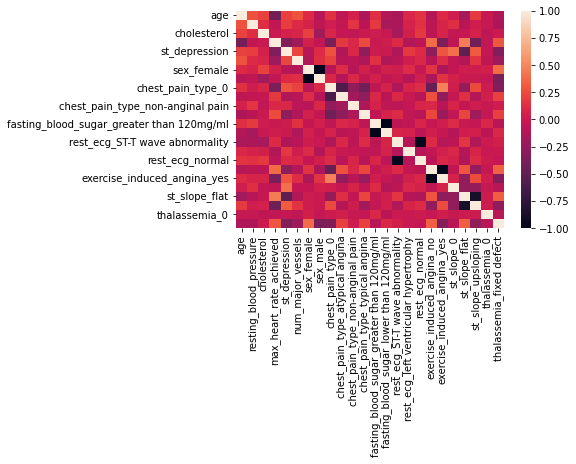

In [111]:
sns.heatmap(data.corr())

In [185]:
# number of total training points
num_train = len(X_train_encoded)
print("Number of training points: ", num_train)

#number of testing points
num_test = len(X_test_encoded)
print("Number of testing points: ", num_test)

Number of training points:  242
Number of testing points:  61


In [189]:
# create an instance of logistic regression
from sklearn import linear_model
cls = linear_model.LogisticRegression()

# fit the model to training data
cls.fit(X_train_encoded, y_train)

# make prediction
predictions = cls.predict(X_test_encoded)

overral_score = cls.score(X_test_encoded, y_test)
print('Accuracy: {:.2f}%'.format(overral_score * 100))

Accuracy: 78.69%


##Which of the 2 models performs better in terms of the above metrics?  


Summary for RandomForestClassifier model

In [125]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred_rf = model.predict(X_test_encoded)
print('Random Forest Classifier')
print('Accuracy: {:.2f}%'.format(score * 100))
print("Classification Report")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred_rf))

Random Forest Classifier
Accuracy: 80.33%
Classification Report
              precision    recall  f1-score   support

           0       0.87      0.77      0.82        35
           1       0.73      0.85      0.79        26

    accuracy                           0.80        61
   macro avg       0.80      0.81      0.80        61
weighted avg       0.81      0.80      0.80        61

Confusion Matrix
[[27  8]
 [ 4 22]]


Summary for LogisticRegression model

In [128]:
y_pred_lr = cls.predict(X_test_encoded)
print('Logistic Regression')
print('Accuracy: {:.2f}%'.format(overral_score * 100))
print("Classification Report")
print(classification_report(y_test, y_pred_lr))
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred_lr))

Logistic Regression
Accuracy: 78.69%
Classification Report
              precision    recall  f1-score   support

           0       0.82      0.80      0.81        35
           1       0.74      0.77      0.75        26

    accuracy                           0.79        61
   macro avg       0.78      0.78      0.78        61
weighted avg       0.79      0.79      0.79        61

Confusion Matrix
[[28  7]
 [ 6 20]]


Based on the reports above, the Random Forest Classifier model performs better than the Logistic Regression model. It has higher accuracy, precision, recall, and F1-score for the positive class (1), and fewer false positives and false negatives.

#Fairness measurement<a id='section4'></a>

###ROC curve for all the records for model 1 -- RandomForestClassifer. 


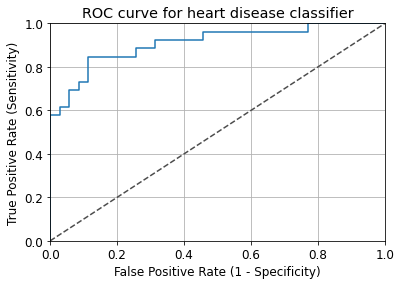

In [159]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_quant)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for heart disease classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

##Observation


The ROC curve is a plot of the true positive rate (sensitivity) against the false positive rate (1-specificity) for different threshold values of the classifier. The plot also includes a dashed line that represents the ROC curve of a random classifier. By looking at the plot, we can observe how well the classifier is performing. If the ROC curve is close to the top-left corner of the plot, the classifier is performing well, while if it is close to the diagonal line, the classifier is no better than random guessing.

# Explainability 




###Useful Practice

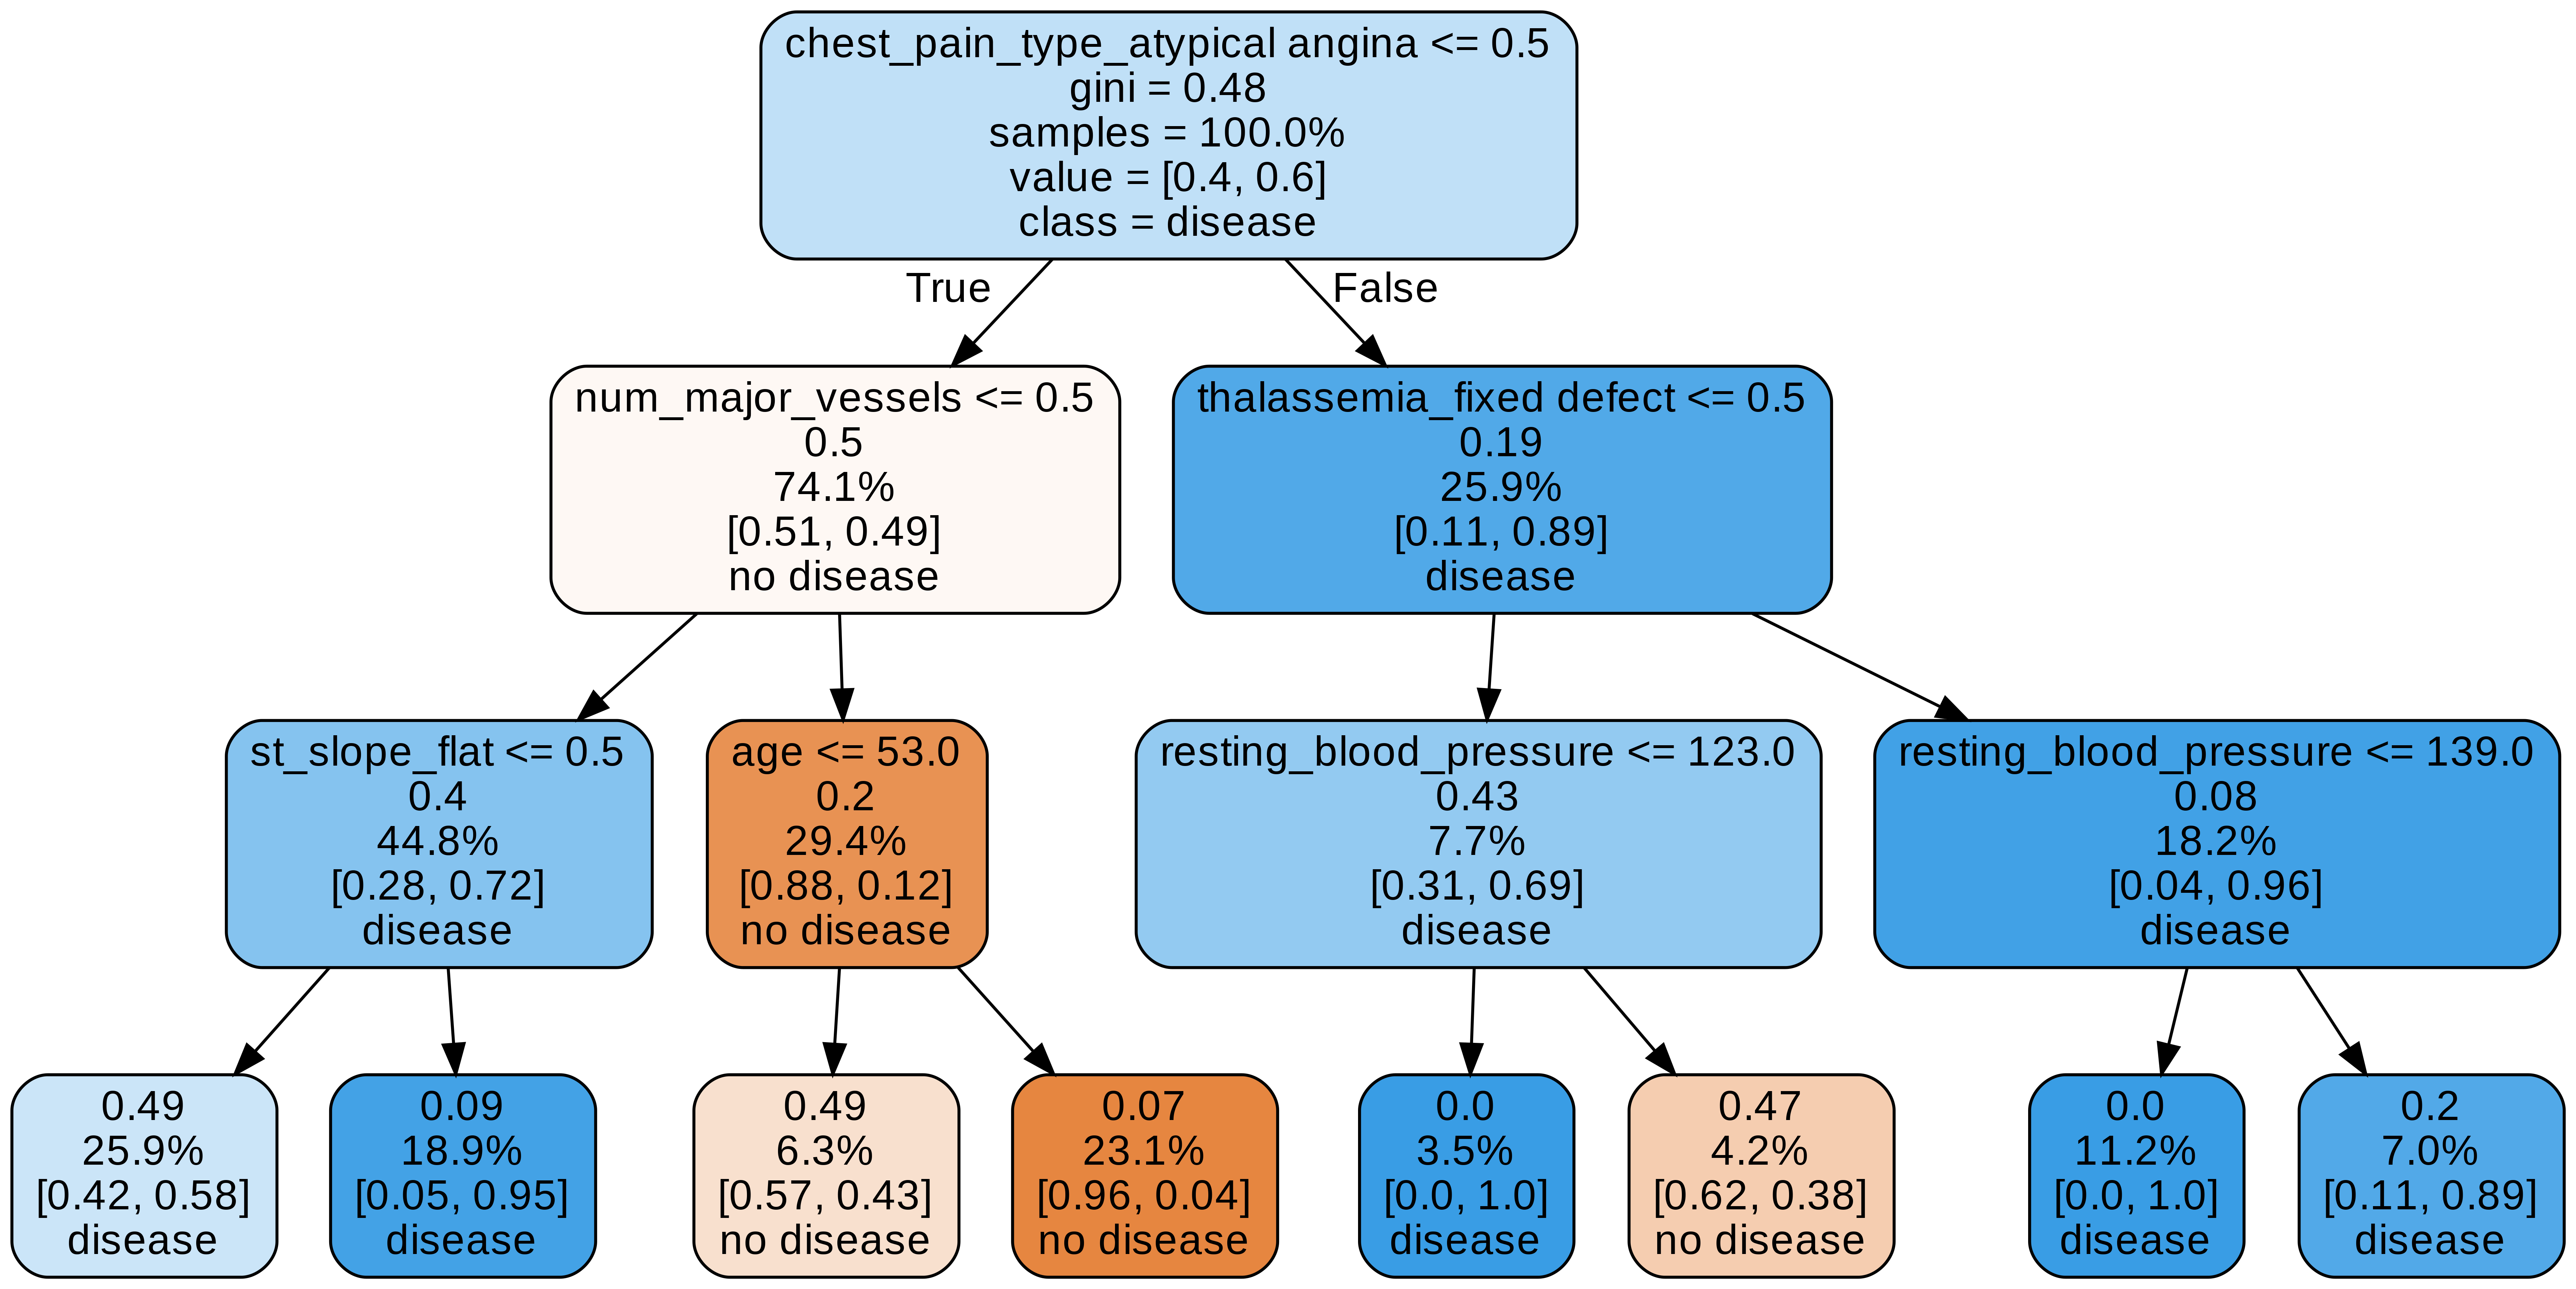

In [ ]:
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = feature_names,
                class_names = y_train_str,
                rounded = True, proportion = True, 
                label='root',
                precision = 2, filled = True)

from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

from IPython.display import Image
Image(filename = 'tree.png')

### Permutation importance

Write a method to calculate and present the premutation importance of the features that each model is using. 

In [229]:
from sklearn.inspection import permutation_importance

def present_permutation_importance(cls, model, X_test, y_test):
    # create an instance of the permutation importance class
    perm_importance = permutation_importance(model, X_test, y_test)

    # get the feature importances
    feature_importances = perm_importance.importances_mean

    # get the feature names
    feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_features).tolist() + num_features

    # sort the features by importance score
    sorted_idx = feature_importances.argsort()[::-1]

    # print the feature importance scores and names
    print("Feature importance scores:")
    for i in sorted_idx:
        print('{:<20} {:.3f}'.format(feature_names[i], feature_importances[i]))

    # create a bar chart of feature importance scores
    plt.bar(range(X_test.shape[1]), feature_importances[sorted_idx])
    plt.xticks(range(X_test.shape[1]), np.array(feature_names)[sorted_idx], rotation=90)
    plt.xlabel("Feature name")
    plt.ylabel("Feature importance score")
    plt.title("{} feature importance".format(type(cls).__name__))
    plt.show()




Feature importance scores:
num_major_vessels    0.036
max_heart_rate_achieved 0.036
chest_pain_type_non-anginal pain 0.007
chest_pain_type_0    0.003
fasting_blood_sugar_greater than 120mg/ml 0.003
fasting_blood_sugar_lower than 120mg/ml 0.003
exercise_induced_angina_no 0.003
st_slope_upsloping   0.000
st_depression        0.000
st_slope_0           0.000
exercise_induced_angina_yes 0.000
thalassemia_reversable defect 0.000
age                  0.000
cholesterol          0.000
rest_ecg_left ventricular hypertrophy -0.003
rest_ecg_ST-T wave abnormality -0.003
resting_blood_pressure -0.003
sex_female           -0.003
st_slope_flat        -0.013
thalassemia_fixed defect -0.013
thalassemia_normal   -0.013
rest_ecg_normal      -0.013
chest_pain_type_typical angina -0.016
chest_pain_type_atypical angina -0.020
thalassemia_0        -0.023
sex_male             -0.036


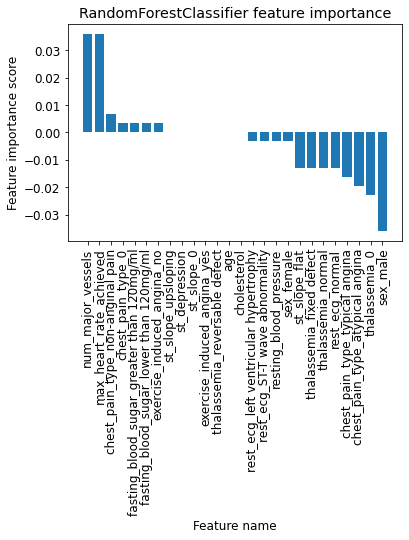

In [232]:
# call the function to present permutation importance for Random Forest model
present_permutation_importance(model, cls, X_test_encoded, y_test)

Feature importance scores:
max_heart_rate_achieved 0.013
chest_pain_type_non-anginal pain 0.000
exercise_induced_angina_yes 0.000
fasting_blood_sugar_lower than 120mg/ml 0.000
cholesterol          0.000
sex_male             0.000
thalassemia_reversable defect 0.000
fasting_blood_sugar_greater than 120mg/ml 0.000
thalassemia_0        0.000
st_slope_upsloping   0.000
st_slope_flat        0.000
st_slope_0           0.000
st_depression        0.000
exercise_induced_angina_no 0.000
rest_ecg_normal      0.000
thalassemia_normal   -0.003
num_major_vessels    -0.007
chest_pain_type_0    -0.010
thalassemia_fixed defect -0.013
sex_female           -0.013
rest_ecg_ST-T wave abnormality -0.016
chest_pain_type_typical angina -0.016
age                  -0.020
resting_blood_pressure -0.020
rest_ecg_left ventricular hypertrophy -0.036
chest_pain_type_atypical angina -0.039


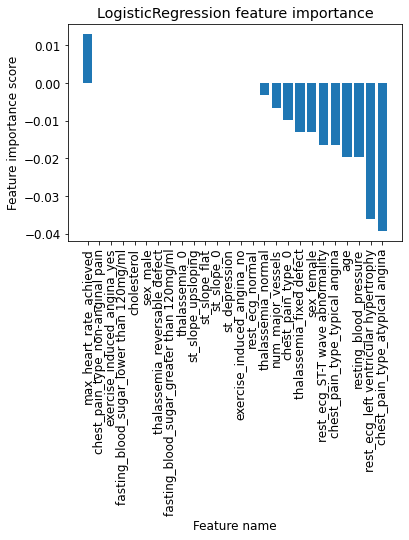

In [233]:
# call the function to present permutation importance for Logistic Regression model
present_permutation_importance(cls, model, X_test_encoded, y_test)


### Observation

Based on the permutation importance analysis, the most important feature for the Random Forest model is "num_major_vessels" and "max_heart_rate_achieved", both with a score of 0.036. The least important features are "st_slope_0", "exercise_induced_angina_yes", "thalassemia_reversable defect", "thalassemia_normal", and "chest_pain_type_typical angina", all with a score of 0.000 or less.

For the Logistic Regression model, the most important feature is "max_heart_rate_achieved" with a score of 0.013. The least important features are "rest_ecg_left ventricular hypertrophy" and "chest_pain_type_atypical angina", both with a score of -0.039.